<a href="https://colab.research.google.com/github/disha2sinha/Movie-Recommendation-System/blob/master/Content_Based_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from ast import literal_eval
import pandas as pd
import math
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import matplotlib.pyplot as plt
import scipy.sparse
from sklearn.metrics.pairwise import cosine_similarity
import os
from sklearn.cluster import KMeans

In [24]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## **IMPORTING MOVIES DATASET WHICH WAS PREVIOUSLY ARRANGED ACCORDING TO POPULARITY**

In [25]:
id='1wQEIJenO8lzY6VWpEvS8-bkkVpXOG90y'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('PopularMovies.csv') 
movies_data = pd.read_csv('PopularMovies.csv',engine='python',index_col=0)
movies_data.head()

,tmdbId,title,budget,profit,score,release_year,release_day,keywords,genres,production_countries,production_companies,original_language,runtime,content,status,cast,director
0,211672,Minions,74000000,1.082731e+09,0.634881,2015,Wednesday,"['assistant', 'aftercreditsstinger', 'duringcr...",Family|Animation|Adventure|Comedy,United States of America,Universal Pictures|Illumination Entertainment,English,91.0,"Minions Stuart, Kevin and Bob are recruited by...",Released,Sandra Bullock|Jon Hamm|Michael Keaton|Allison...,Kyle Balda
1,177572,Big Hero 6,165000000,4.871054e+08,0.598368,2014,Friday,"['brother brother relationship', 'hero', 'tale...",Adventure|Family|Animation|Action|Comedy,United States of America,Walt Disney Pictures|Walt Disney Animation Stu...,English,102.0,The special bond that develops between plus-si...,Released,Scott Adsit|Ryan Potter|Daniel Henney|T.J. Mil...,Chris Williams
2,155,The Dark Knight,185000000,8.195584e+08,0.565743,2008,Wednesday,"['dc comics', 'crime fighter', 'secret identit...",Drama|Action|Crime|Thriller,United Kingdom|United States of America,DC Comics|Legendary Pictures|Warner Bros.|DC E...,English,152.0,Batman raises the stakes in his war on crime. ...,Released,Christian Bale|Michael Caine|Heath Ledger|Aaro...,Christopher Nolan
3,680,Pulp Fiction,8000000,2.059288e+08,0.558571,1994,Saturday,"['transporter', 'brothel', 'drug dealer', 'box...",Thriller|Crime,United States of America,Miramax Films|A Band Apart|Jersey Films,English,154.0,"A burger-loving hit man, his philosophical par...",Released,John Travolta|Samuel L. Jackson|Uma Thurman|Br...,Quentin Tarantino
4,278,The Shawshank Redemption,25000000,3.341469e+06,0.554077,1994,Friday,"['prison', 'corruption', 'police brutality', '...",Drama|Crime,United States of America,Castle Rock Entertainment|Warner Bros.,English,142.0,Framed in the 1940s for the double murder of h...,Released,Tim Robbins|Morgan Freeman|Bob Gunton|Clancy B...,Frank Darabont


In [26]:
movies_data.shape

(9081, 17)

In [27]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9081 entries, 0 to 9080
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tmdbId                9081 non-null   int64  
 1   title                 9081 non-null   object 
 2   budget                9081 non-null   int64  
 3   profit                9081 non-null   float64
 4   score                 9081 non-null   float64
 5   release_year          9081 non-null   int64  
 6   release_day           9081 non-null   object 
 7   keywords              9081 non-null   object 
 8   genres                9046 non-null   object 
 9   production_countries  8787 non-null   object 
 10  production_companies  8417 non-null   object 
 11  original_language     9079 non-null   object 
 12  runtime               9081 non-null   float64
 13  content               9069 non-null   object 
 14  status                9081 non-null   object 
 15  cast                 

In [28]:
movies_data=movies_data.replace(np.nan,'Unknown',regex=True)
movies_data['release_year']=movies_data['release_year'].replace('NaT','1874',regex=True)

In [29]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9081 entries, 0 to 9080
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tmdbId                9081 non-null   int64  
 1   title                 9081 non-null   object 
 2   budget                9081 non-null   int64  
 3   profit                9081 non-null   float64
 4   score                 9081 non-null   float64
 5   release_year          9081 non-null   int64  
 6   release_day           9081 non-null   object 
 7   keywords              9081 non-null   object 
 8   genres                9081 non-null   object 
 9   production_countries  9081 non-null   object 
 10  production_companies  9081 non-null   object 
 11  original_language     9081 non-null   object 
 12  runtime               9081 non-null   float64
 13  content               9081 non-null   object 
 14  status                9081 non-null   object 
 15  cast                 

## **KEYWORDS ARE FORMED FROM ALL THE NON-NUMERIC COLUMNS**

In [30]:
movies_data['production_companies']=movies_data['production_companies'].str.replace(" ","")
movies_data['production_companies']=movies_data['production_companies'].str.replace("|","  ")
movies_data['production_countries']=movies_data['production_countries'].str.replace(" ","")
movies_data['production_countries']=movies_data['production_countries'].str.replace("|","  ")
movies_data['cast']=movies_data['cast'].str.replace(" ","")
movies_data['cast']=movies_data['cast'].str.replace("|","  ")
movies_data['genres']=movies_data['genres'].str.replace("|"," ")
movies_data['director']=movies_data['director'].str.replace(" ","")
movies_data['keywords']=movies_data['keywords'].apply(lambda x:x[1:-1])
movies_data['keywords']=movies_data['keywords'].str.replace(',',"  ")
movies_data['keywords']=movies_data['keywords'].str.replace("'","")
movies_data.head(10)

,tmdbId,title,budget,profit,score,release_year,release_day,keywords,genres,production_countries,production_companies,original_language,runtime,content,status,cast,director
0,211672,Minions,74000000,1.082731e+09,0.634881,2015,Wednesday,assistant aftercreditsstinger duringcredit...,Family Animation Adventure Comedy,UnitedStatesofAmerica,UniversalPictures IlluminationEntertainment,English,91.0,"Minions Stuart, Kevin and Bob are recruited by...",Released,SandraBullock JonHamm MichaelKeaton Allison...,KyleBalda
1,177572,Big Hero 6,165000000,4.871054e+08,0.598368,2014,Friday,brother brother relationship hero talent ...,Adventure Family Animation Action Comedy,UnitedStatesofAmerica,WaltDisneyPictures WaltDisneyAnimationStudios,English,102.0,The special bond that develops between plus-si...,Released,ScottAdsit RyanPotter DanielHenney T.J.Mill...,ChrisWilliams
2,155,The Dark Knight,185000000,8.195584e+08,0.565743,2008,Wednesday,dc comics crime fighter secret identity ...,Drama Action Crime Thriller,UnitedKingdom UnitedStatesofAmerica,DCComics LegendaryPictures WarnerBros. DCEn...,English,152.0,Batman raises the stakes in his war on crime. ...,Released,ChristianBale MichaelCaine HeathLedger Aaro...,ChristopherNolan
3,680,Pulp Fiction,8000000,2.059288e+08,0.558571,1994,Saturday,transporter brothel drug dealer boxer ...,Thriller Crime,UnitedStatesofAmerica,MiramaxFilms ABandApart JerseyFilms,English,154.0,"A burger-loving hit man, his philosophical par...",Released,JohnTravolta SamuelL.Jackson UmaThurman Bru...,QuentinTarantino
4,278,The Shawshank Redemption,25000000,3.341469e+06,0.554077,1994,Friday,prison corruption police brutality priso...,Drama Crime,UnitedStatesofAmerica,CastleRockEntertainment WarnerBros.,English,142.0,Framed in the 1940s for the double murder of h...,Released,TimRobbins MorganFreeman BobGunton ClancyBr...,FrankDarabont
5,210577,Gone Girl,61000000,3.083304e+08,0.523202,2014,Wednesday,based on novel marriage crisis disappearan...,Mystery Thriller Drama,UnitedStatesofAmerica,TwentiethCenturyFoxFilmCorporation RegencyEnt...,English,145.0,With his wife's disappearance having become th...,Released,BenAffleck RosamundPike CarrieCoon NeilPatr...,DavidFincher
6,293660,Deadpool,58000000,7.251130e+08,0.518324,2016,Tuesday,anti hero mercenary marvel comic superhe...,Action Adventure Comedy,UnitedStatesofAmerica,TwentiethCenturyFoxFilmCorporation MarvelEnte...,English,108.0,Deadpool tells the origin story of former Spec...,Released,RyanReynolds MorenaBaccarin EdSkrein T.J.Mi...,TimMiller
7,157336,Interstellar,165000000,5.101200e+08,0.514384,2014,Wednesday,saving the world artificial intelligence f...,Adventure Drama Science Fiction,Canada UnitedStatesofAmerica UnitedKingdom,ParamountPictures LegendaryPictures WarnerBr...,English,169.0,Interstellar chronicles the adventures of a gr...,Released,MatthewMcConaughey JessicaChastain AnneHatha...,ChristopherNolan
8,550,Fight Club,63000000,3.785375e+07,0.495441,1999,Friday,support group dual identity nihilism rag...,Drama,Germany UnitedStatesofAmerica,TwentiethCenturyFoxFilmCorporation RegencyEnt...,English,139.0,A ticking-time-bomb insomniac and a slippery s...,Released,EdwardNorton BradPitt MeatLoaf JaredLeto H...,DavidFincher
9,118340,Guardians of the Galaxy,170000000,6.033286e+08,0.484757,2014,Wednesday,marvel comic spaceship space outer space...,Action Science Fiction Adventure,UnitedKingdom UnitedStatesofAmerica,MarvelStudios MovingPictureCompany(MPC) Bull...,English,121.0,"Light years from Earth, 26 years after being a...",Released,ChrisPratt ZoeSaldana DaveBautista VinDiese...,JamesGunn


In [31]:
movies_data['keywords']=movies_data['keywords']+" " +movies_data['cast']+" "+movies_data['production_companies']+" "+movies_data['production_countries']+" "+movies_data['genres']+" "+movies_data['original_language']+" "+movies_data['release_day']+" "+movies_data['content']+" "+movies_data['director']
movies_data['keywords']=movies_data['keywords'].replace({"[^A-Za-z0-9]+": " "},regex=True)
movies_data['keywords'][0]

'assistant aftercreditsstinger duringcreditsstinger evil mastermind minions 3d SandraBullock JonHamm MichaelKeaton AllisonJanney SteveCoogan JenniferSaunders GeoffreyRush SteveCarell PierreCoffin KatyMixon MichaelBeattie HiroyukiSanada DaveRosenbaum AlexDowding PaulThornley KyleBalda AvaAcres UniversalPictures IlluminationEntertainment UnitedStatesofAmerica Family Animation Adventure Comedy English Wednesday Minions Stuart Kevin and Bob are recruited by Scarlet Overkill a super villain who alongside her inventor husband Herb hatches a plot to take over the world Before Gru they had a history of bad bosses KyleBalda'

## **WORD VECTORIZER IS CREATED FROM THE KEYWORDS AND A NEW DATAFRAME IS FORMED COMBINING THE NUMERIC COLUMNS AND WORD VECTORIZER FOR EACH MOVIE ID**

In [32]:
vectorizer=TfidfVectorizer(analyzer='word',stop_words='english')
X=vectorizer.fit_transform(movies_data['keywords'])
tfidf_df=pd.DataFrame.sparse.from_spmatrix(X)

In [33]:
movies_df=movies_data[['tmdbId','budget','profit','score','release_year','runtime']]
movies_df=movies_df.join(tfidf_df)
movies_df.set_index('tmdbId',inplace=True)
movies_df.shape

In [34]:
dftomat=scipy.sparse.csr_matrix(movies_df.values)

In [35]:
dftomat[1,:].toarray()

array([[1.65000000e+08, 4.87105443e+08, 5.98367835e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [36]:
dftomat.shape

(9081, 124699)

## **PERFORMING KMeans ON THE NEW DATAFRAME TO FORM CLUSTERS OF SIMILAR MOVIES:**

### **FINDING OPTIMAL K USING ELBOW METHOD**

K= 4
K= 5
K= 6
K= 7
K= 8
K= 9
K= 10
K= 11
K= 12
K= 13
K= 14


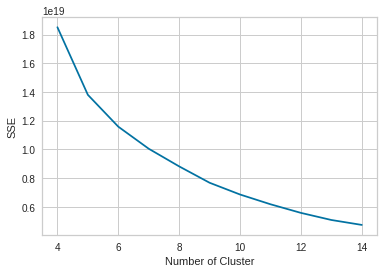

In [37]:
#sse={}
#for k in range(4,15):
  #print("K=",k)
  #kmeans=KMeans(n_clusters=k,init='k-means++',max_iter=100).fit(dftomat)
  #sse[k]=kmeans.inertia_
#plt.plot(list(sse.keys()),list(sse.values()),'bx-')
#plt.xlabel("Number of Cluster")
#plt.ylabel("SSE")
#plt.savefig("elbow_method.png")

In [40]:
kmeans=KMeans(n_clusters=4,init='k-means++',max_iter=500).fit(dftomat)
movies_df['KmeansCluster']=kmeans.labels_

In [41]:
print(movies_df[movies_df['KmeansCluster']==0].count())
print(movies_df[movies_df['KmeansCluster']==1].count())
print(movies_df[movies_df['KmeansCluster']==2].count())
print(movies_df[movies_df['KmeansCluster']==3].count())

budget           8067
profit           8067
score            8067
release_year     8067
runtime          8067
                 ... 
124690           8067
124691           8067
124692           8067
124693           8067
KmeansCluster    8067
Length: 124700, dtype: int64
budget           195
profit           195
score            195
release_year     195
runtime          195
                ... 
124690           195
124691           195
124692           195
124693           195
KmeansCluster    195
Length: 124700, dtype: int64
budget           764
profit           764
score            764
release_year     764
runtime          764
                ... 
124690           764
124691           764
124692           764
124693           764
KmeansCluster    764
Length: 124700, dtype: int64
budget           55
profit           55
score            55
release_year     55
runtime          55
                 ..
124690           55
124691           55
124692           55
124693           55
KmeansClu